Goal :
1.Apply optimization methods such as (Stochastic) Gradient Descent, Momentum, RMSProp and Adam
2. Use random minibatches to accelerate convergence and improve optimization

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import sklearn
import sklearn.datasets
from copy import deepcopy

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# Lets Start with Normal gradient Descent

def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent

    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.

    Returns:
    parameters -- python dictionary containing your updated parameters
    """
    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]
    return parameters

In [4]:
#let test it
np.random.seed(1)
learning_rate = 0.01
W1 = np.random.randn(2,3)
b1 = np.random.randn(2,1)
W2 = np.random.randn(3,2)
b2 = np.random.randn(3,1)
dW1 = np.random.randn(2,3)
db1 = np.random.randn(2,1)
dW2 = np.random.randn(3,2)
db2 = np.random.randn(3,1)
    
parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

parameters = update_parameters_with_gd(parameters, grads, learning_rate)

print("W1 =\n" + str(parameters["W1"]))
print("b1 =\n" + str(parameters["b1"]))
print("W2 =\n" + str(parameters["W2"]))
print("b2 =\n" + str(parameters["b2"]))

W1 =
[[ 1.63312395 -0.61217855 -0.5339999 ]
 [-1.06196243  0.85396039 -2.3105546 ]]
b1 =
[[ 1.73978682]
 [-0.77021546]]
W2 =
[[ 0.32587637 -0.24814147]
 [ 1.47146563 -2.05746183]
 [-0.32772076 -0.37713775]]
b2 =
[[ 1.13773698]
 [-1.09301954]
 [-0.16397615]]


# In Stochastic Gradient Descent, you use only 1 training example before updating the gradients.
When the training set is large, SGD can be faster. 
But the parameters will "oscillate" toward the minimum rather than converge smoothly.

Mini-batch gradient descent uses an intermediate number of examples for each step. 
With mini-batch gradient descent, you loop over the mini-batches instead of looping over individual training examples
Shuffling and Partitioning are the two steps required to build mini-batches
Powers of two are often chosen to be the mini-batch size, e.g., 16, 32, 64, 128.

In [6]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    np.random.seed(seed)            # To make your "random" minibatches the same as mine
    m = X.shape[1]                  # number of training examples
    mini_batches = []

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))

    inc = mini_batch_size

    # Step 2 - Partition (shuffled_X, shuffled_Y).
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):

        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size : m]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [8]:
#lets test

np.random.seed(1)
mini_batch_size = 64
X = np.random.randn(12288, 148)
Y = np.random.randn(1, 148) < 0.5
mini_batches = random_mini_batches(X, Y, mini_batch_size)
print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape))
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))


shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]


## Momentum

In [10]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL"
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl

    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}

    # Initialize velocity
    for l in range(1, L + 1):

        v["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        v["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])

    return v

In [11]:
#lets test
np.random.seed(1)
W1 = np.random.randn(3,2)
b1 = np.random.randn(3,1)
W2 = np.random.randn(3,3)
b2 = np.random.randn(3,1)
parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
v = initialize_velocity(parameters)
print("v[\"dW1\"] =\n" + str(v["dW1"]))
print("v[\"db1\"] =\n" + str(v["db1"]))
print("v[\"dW2\"] =\n" + str(v["dW2"]))
print("v[\"db2\"] =\n" + str(v["db2"]))


v["dW1"] =
[[0. 0.]
 [0. 0.]
 [0. 0.]]
v["db1"] =
[[0.]
 [0.]
 [0.]]
v["dW2"] =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] =
[[0.]
 [0.]
 [0.]]


In [13]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum

    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar

    Returns:
    parameters -- python dictionary containing your updated parameters
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2 # number of layers in the neural networks

    # Momentum update for each parameter
    for l in range(1, L + 1):
        # compute velocities
        v["dW" + str(l)] = beta * v["dW" + str(l)] + (1 - beta) * grads["dW" + str(l)]
        v["db" + str(l)] = beta * v["db" + str(l)] + (1 - beta) * grads["db" + str(l)]
        
        # update parameters
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v["db" + str(l)]
    return parameters, v

In [14]:
#Lets test Momentum update
np.random.seed(1)
W1 = np.random.randn(2,3)
b1 = np.random.randn(2,1)
W2 = np.random.randn(3,2)
b2 = np.random.randn(3,1)

dW1 = np.random.randn(2,3)
db1 = np.random.randn(2,1)
dW2 = np.random.randn(3,2)
db2 = np.random.randn(3,1)
   
parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

v = {'dW1': np.array([[ 0.,  0.,  0.],
                          [ 0.,  0.,  0.]]), 
         'dW2': np.array([[ 0.,  0.],
                          [ 0.,  0.],
                          [ 0.,  0.]]), 
         'db1': np.array([[ 0.],
                          [ 0.]]), 
         'db2': np.array([[ 0.],
                          [ 0.],
                          [ 0.]])}

parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = \n" + str(parameters["W1"]))
print("b1 = \n" + str(parameters["b1"]))
print("W2 = \n" + str(parameters["W2"]))
print("b2 = \n" + str(parameters["b2"]))
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = v" + str(v["db2"]))
    

W1 = 
[[ 1.62522322 -0.61179863 -0.52875457]
 [-1.071868    0.86426291 -2.30244029]]
b1 = 
[[ 1.74430927]
 [-0.76210776]]
W2 = 
[[ 0.31972282 -0.24924749]
 [ 1.46304371 -2.05987282]
 [-0.32294756 -0.38336269]]
b2 = 
[[ 1.1341662 ]
 [-1.09920409]
 [-0.171583  ]]
v["dW1"] = 
[[-0.08778584  0.00422137  0.05828152]
 [-0.11006192  0.11447237  0.09015907]]
v["db1"] = 
[[0.05024943]
 [0.09008559]]
v["dW2"] = 
[[-0.06837279 -0.01228902]
 [-0.09357694 -0.02678881]
 [ 0.05303555 -0.06916608]]
v["db2"] = v[[-0.03967535]
 [-0.06871727]
 [-0.08452056]]


The larger the momentum  𝛽 is, the smoother the update, because it takes the past gradients into account more.
But if  𝛽 is too big, it could also smooth out the updates too much.
Common values for  𝛽 range from 0.8 to 0.999. If you don't feel inclined to tune this,  𝛽=0.9 is often a reasonable default.
Tuning the optimal  𝛽 for your model might require trying several values to see what works best in terms of reducing the value of the cost function  𝐽.

## Adam

Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp and Momentum.

How does Adam work?

1. It calculates an exponentially weighted average of past gradients, and stores it in variables  𝑣 (before bias correction) and  𝑣𝑐𝑜𝑟𝑟𝑒𝑐𝑡𝑒𝑑 (with bias correction).
2. It calculates an exponentially weighted average of the squares of the past gradients, and stores it in variables  𝑠 (before bias correction) and  𝑠𝑐𝑜𝑟𝑟𝑒𝑐𝑡𝑒𝑑 (with bias correction).
3. It updates parameters in a direction based on combining information from "1" and "2".

In [16]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL"
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.

    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl

    Returns:
    v -- python dictionary that will contain the exponentially weighted average of the gradient. Initialized with zeros.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient. Initialized with zeros.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """

    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}

    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1, L + 1):

        v["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        v["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
        s["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        s["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])

    return v, s

In [19]:
#Lets test the initialization
np.random.seed(1)
W1 = np.random.randn(2,3)
b1 = np.random.randn(2,1)
W2 = np.random.randn(3,2)
b2 = np.random.randn(3,1)
parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}


v, s = initialize_adam(parameters)
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = \n" + str(v["db2"]))
print("s[\"dW1\"] = \n" + str(s["dW1"]))
print("s[\"db1\"] = \n" + str(s["db1"]))
print("s[\"dW2\"] = \n" + str(s["dW2"]))
print("s[\"db2\"] = \n" + str(s["db2"]))


v["dW1"] = 
[[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = 
[[0.]
 [0.]]
v["dW2"] = 
[[0. 0.]
 [0. 0.]
 [0. 0.]]
v["db2"] = 
[[0.]
 [0.]
 [0.]]
s["dW1"] = 
[[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = 
[[0.]
 [0.]]
s["dW2"] = 
[[0. 0.]
 [0. 0.]
 [0. 0.]]
s["db2"] = 
[[0.]
 [0.]
 [0.]]


In [20]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using the Adam optimization algorithm.

    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameter:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, maintained as a python dictionary
    s -- Adam variable, moving average of the squared gradient, maintained as a python dictionary
    t -- Adam variable, counts the number of steps taken for bias correction
    learning_rate -- learning rate, scalar
    beta1 -- exponential decay hyperparameter for the first moment estimates
    beta2 -- exponential decay hyperparameter for the second moment estimates
    epsilon -- hyperparameter to prevent division by zero in the Adam update, a small scalar

    Returns:
    parameters -- python dictionary containing your updated parameters
    v -- updated Adam variable, moving average of the first gradient, python dictionary
    s -- updated Adam variable, moving average of the squared gradient, python dictionary
    v_corrected -- python dictionary containing bias-corrected first moment estimates
    s_corrected -- python dictionary containing bias-corrected second moment estimates
    """

    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary

    # Perform Adam update on all parameters
    for l in range(1, L + 1):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads["dW" + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads["db" + str(l)]
        
        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - np.power(beta1, t))
        
        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * np.power(grads["dW" + str(l)], 2)
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * np.power(grads["db" + str(l)], 2)
        
        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - np.power(beta2, t))
        
        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + epsilon)
    return parameters, v, s, v_corrected, s_corrected

In [21]:
def update_parameters_with_adam_test_case():
    np.random.seed(1)
    v, s = ({'dW1': np.array([[ 0.,  0.,  0.], # (2, 3)
                              [ 0.,  0.,  0.]]), 
             'dW2': np.array([[ 0.,  0.],      # (3, 2)
                              [ 0.,  0.],
                              [ 0.,  0.]]), 
             'db1': np.array([[ 0.],           # (2, 1)
                              [ 0.]]), 
             'db2': np.array([[ 0.],          # (3, 1)
                              [ 0.],
                              [ 0.]])}, 
            {'dW1': np.array([[ 0.,  0.,  0.], # (2, 3)
                              [ 0.,  0.,  0.]]), 
             'dW2': np.array([[ 0.,  0.],      # (3, 2)
                              [ 0.,  0.],
                              [ 0.,  0.]]), 
             'db1': np.array([[ 0.],           # (2, 1)
                              [ 0.]]), 
             'db2': np.array([[ 0.],           # (3, 1)
                              [ 0.],
                              [ 0.]])})
    W1 = np.random.randn(2,3)
    b1 = np.random.randn(2,1)
    W2 = np.random.randn(3,2)
    b2 = np.random.randn(3,1)

    dW1 = np.random.randn(2,3)
    db1 = np.random.randn(2,1)
    dW2 = np.random.randn(3,2)
    db2 = np.random.randn(3,1)
    
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    
    t = 2
    learning_rate = 0.02
    beta1 = 0.8
    beta2 = 0.888
    epsilon = 1e-2
    
    return parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon

parametersi, grads, vi, si, t, learning_rate, beta1, beta2, epsilon = update_parameters_with_adam_test_case()

parameters, v, s, vc, sc  = update_parameters_with_adam(parametersi, grads, vi, si, t, learning_rate, beta1, beta2, epsilon)
print(f"W1 = \n{parameters['W1']}")
print(f"W2 = \n{parameters['W2']}")
print(f"b1 = \n{parameters['b1']}")
print(f"b2 = \n{parameters['b2']}")

W1 = 
[[ 1.63937725 -0.62327448 -0.54308727]
 [-1.0578897   0.85032154 -2.31657668]]
W2 = 
[[ 0.33400549 -0.23563857]
 [ 1.47715417 -2.04561842]
 [-0.33729882 -0.36908457]]
b1 = 
[[ 1.72995096]
 [-0.7762447 ]]
b2 = 
[[ 1.14852557]
 [-1.08492339]
 [-0.15740527]]


## Model with different Optimization algorithms

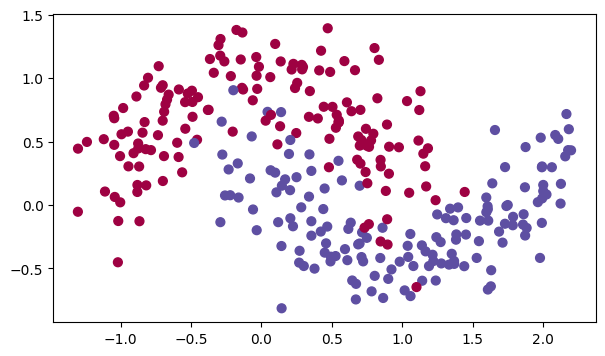

In [23]:
def load_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2 
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

train_X, train_Y = load_dataset()

In [38]:
#Lets us first import some helper functions

def sigmoid(x):
    
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    
    s = np.maximum(0,x)
    
    return s
    
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    b1 -- bias vector of shape (layer_dims[l], 1)
                    Wl -- weight matrix of shape (layer_dims[l-1], layer_dims[l])
                    bl -- bias vector of shape (1, layer_dims[l])
                    
    Tips:
    - For example: the layer_dims for the "Planar Data classification model" would have been [2,2,1]. 
    This means W1's shape was (2,2), b1 was (1,2), W2 was (2,1) and b2 was (1,1). Now you have to generalize it!
    - In the for loop, use parameters['W' + str(l)] to access Wl, where l is the iterative integer.
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*  np.sqrt(2 / layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert parameters['W' + str(l)].shape[0] == layer_dims[l], layer_dims[l-1]
        assert parameters['W' + str(l)].shape[0] == layer_dims[l], 1
        
    return parameters

def compute_cost(a3, Y):
    
    """
    Implement the cost function
    
    Arguments:
    a3 -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3
    
    Returns:
    cost - value of the cost function without dividing by number of training examples
    
    Note: 
    This is used with mini-batches, 
    so we'll first accumulate costs over an entire epoch 
    and then divide by the m training examples
    """
    
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost_total =  np.sum(logprobs)
    
    return cost_total

def forward_propagation(X, parameters):
    """
    Implements the forward propagation (and computes the loss) presented in Figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape ()
                    b1 -- bias vector of shape ()
                    W2 -- weight matrix of shape ()
                    b2 -- bias vector of shape ()
                    W3 -- weight matrix of shape ()
                    b3 -- bias vector of shape ()
    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    """
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = sigmoid(z3)
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache

def backward_propagation(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    m = X.shape[1]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    
    dz3 = 1./m * (a3 - Y)
    dW3 = np.dot(dz3, a2.T)
    db3 = np.sum(dz3, axis=1, keepdims = True)
    
    da2 = np.dot(W3.T, dz3)
    dz2 = np.multiply(da2, np.int64(a2 > 0))
    dW2 = np.dot(dz2, a1.T)
    db2 = np.sum(dz2, axis=1, keepdims = True)
    
    da1 = np.dot(W2.T, dz2)
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T)
    db1 = np.sum(dz1, axis=1, keepdims = True)
    
    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}
    
    return gradients

def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = int)
    
    # Forward propagation
    a3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results

    #print ("predictions: " + str(p[0,:]))
    #print ("true labels: " + str(y[0,:]))
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()
    
def predict_dec(parameters, X):
    
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3 > 0.5)
    return predictions


In [39]:
#Here is a 3-layer model with different optimization methods
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.

    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    optimizer -- the optimizer to be passed, gradient descent, momentum or adam
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples

    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    # Optimization loop
    for i in range(num_epochs):

        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m

        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)

    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

## Mini-Batch Gradient Descent

Cost after epoch 0: 0.702405
Cost after epoch 1000: 0.668101
Cost after epoch 2000: 0.635288
Cost after epoch 3000: 0.600491
Cost after epoch 4000: 0.573367


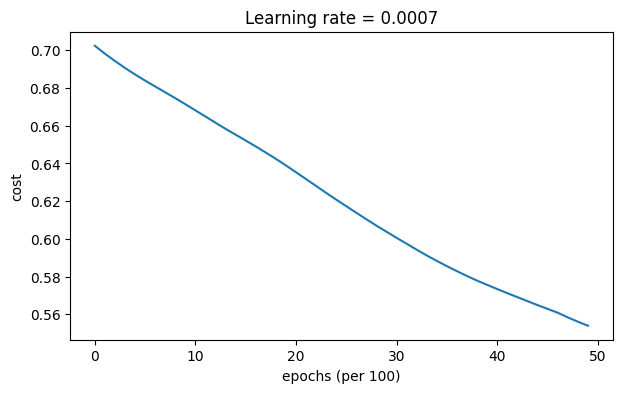

Accuracy: 0.7166666666666667


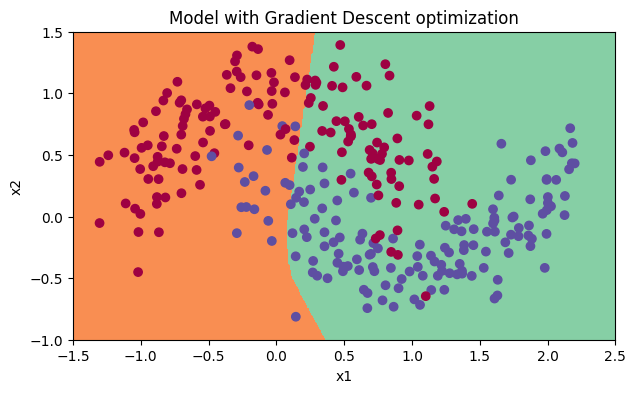

In [40]:
# train 3-layer model with 
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## Mini-Batch Gradient Descent with Momentum

Cost after epoch 0: 0.702413
Cost after epoch 1000: 0.668167
Cost after epoch 2000: 0.635388
Cost after epoch 3000: 0.600591
Cost after epoch 4000: 0.573444


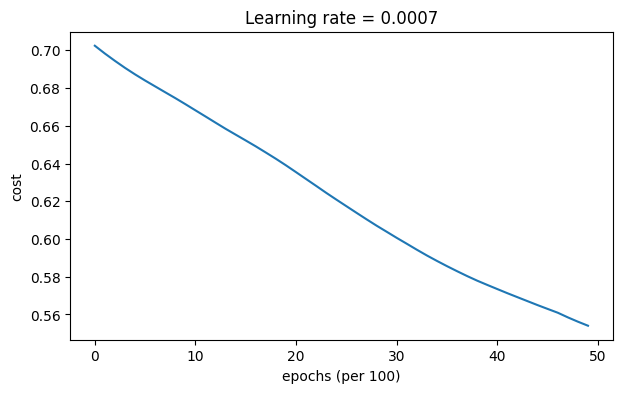

Accuracy: 0.7166666666666667


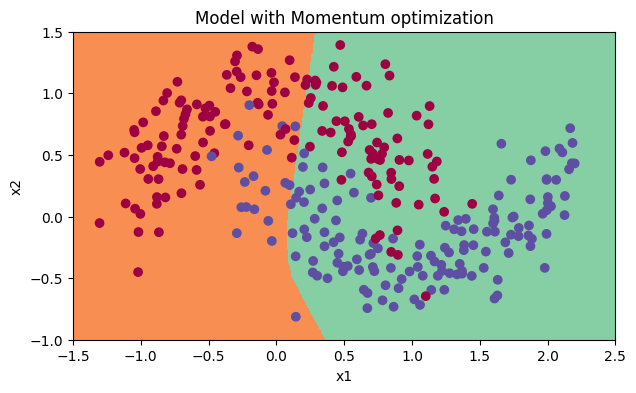

In [41]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## Mini-Batch with Adam

Cost after epoch 0: 0.702166
Cost after epoch 1000: 0.167845
Cost after epoch 2000: 0.141316
Cost after epoch 3000: 0.138788
Cost after epoch 4000: 0.136066


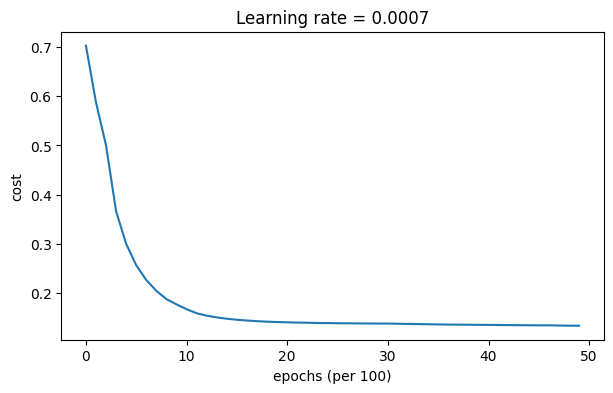

Accuracy: 0.9433333333333334


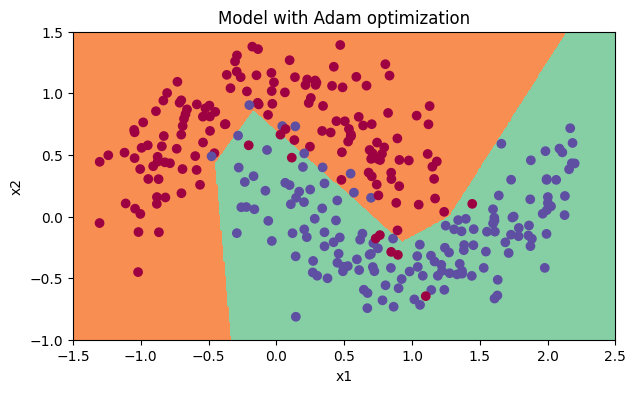

In [42]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## Summary of Results

Momentum usually helps, but given the small learning rate and the simplistic dataset, its impact is almost negligible.

On the other hand, Adam clearly outperforms mini-batch gradient descent and Momentum. If you run the model for more epochs on this simple dataset, all three methods will lead to very good results. However, you've seen that Adam converges a lot faster.

Some advantages of Adam include:

Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum)
Usually works well even with little tuning of hyperparameters (except  𝛼)

Adam Paer: Adam paper: https://arxiv.org/pdf/1412.6980.pdf

## Learning Rate Decay and Scheduling

if you were to slowly reduce your learning rate alpha over time, you could then take smaller, slower steps that bring you closer to the minimum.
This is the idea behind learning rate decay.
We introduce two new parameters, decay and decay_rate.

In [43]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True, decay=None, decay_rate=1):
    """
    3-layer neural network model which can be run in different optimizer modes.

    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    lr_rates = []
    learning_rate0 = learning_rate   # the original learning rate

    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    # Optimization loop
    for i in range(num_epochs):

        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        if decay:
            learning_rate = decay(learning_rate0, i, decay_rate)
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
            if decay:
                print("learning rate after epoch %i: %f"%(i, learning_rate))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)

    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

In [45]:
#Calculate the new learning rate using exponential weight decay.

def update_lr(learning_rate0, epoch_num, decay_rate):

    learning_rate = learning_rate0 / (1 + decay_rate * epoch_num)

    return learning_rate

In [46]:
learning_rate = 0.5
print("Original learning rate: ", learning_rate)
epoch_num = 2
decay_rate = 1
learning_rate_2 = update_lr(learning_rate, epoch_num, decay_rate)

print("Updated learning rate: ", learning_rate_2)


Original learning rate:  0.5
Updated learning rate:  0.16666666666666666


Cost after epoch 0: 0.701091
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.661884
learning rate after epoch 1000: 0.000100
Cost after epoch 2000: 0.658620
learning rate after epoch 2000: 0.000050
Cost after epoch 3000: 0.656765
learning rate after epoch 3000: 0.000033
Cost after epoch 4000: 0.655486
learning rate after epoch 4000: 0.000025


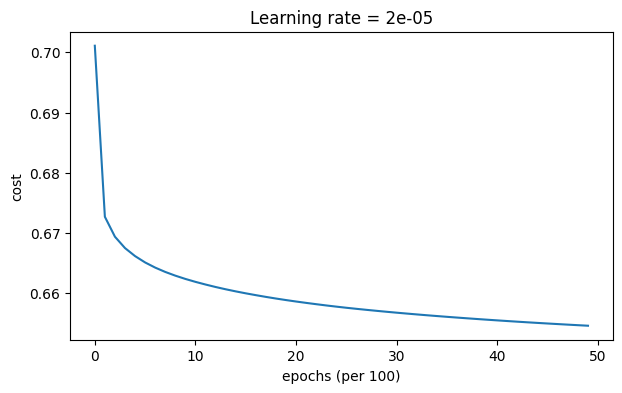

Accuracy: 0.6533333333333333


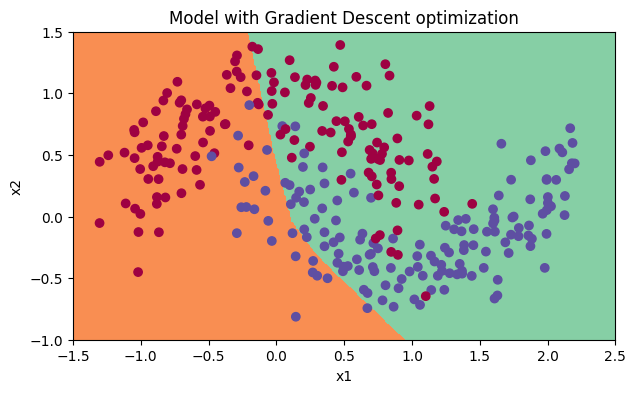

In [47]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd", learning_rate = 0.1, num_epochs=5000, decay=update_lr)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

In [ ]:
#Notice that if you set the decay to occur at every iteration, the learning rate goes to zero too quickly - even if you start with a higher learning rate.


## Fixed Interval Scheduling

learning rate scheduled such that it only changes when the epochNum is a multiple of the timeInterval.

In [48]:
def schedule_lr_decay(learning_rate0, epoch_num, decay_rate, time_interval=1000):
    """
    Calculates updated the learning rate using exponential weight decay.

    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer.
    decay_rate -- Decay rate. Scalar.
    time_interval -- Number of epochs where you update the learning rate.

    Returns:
    learning_rate -- Updated learning rate. Scalar
    """

    learning_rate = learning_rate0 / (1 + decay_rate * np.floor(epoch_num / time_interval))


    return learning_rate
    
learning_rate = 0.5
print("Original learning rate: ", learning_rate)

epoch_num_1 = 10
epoch_num_2 = 100
decay_rate = 0.3
time_interval = 100
learning_rate_1 = schedule_lr_decay(learning_rate, epoch_num_1, decay_rate, time_interval)
learning_rate_2 = schedule_lr_decay(learning_rate, epoch_num_2, decay_rate, time_interval)
print("Updated learning rate after {} epochs: ".format(epoch_num_1), learning_rate_1)
print("Updated learning rate after {} epochs: ".format(epoch_num_2), learning_rate_2)


Original learning rate:  0.5
Updated learning rate after 10 epochs:  0.5
Updated learning rate after 100 epochs:  0.3846153846153846


## Using Learning Rate Decay for each Optimization Method

Cost after epoch 0: 0.701091
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.127161
learning rate after epoch 1000: 0.050000
Cost after epoch 2000: 0.120304
learning rate after epoch 2000: 0.033333
Cost after epoch 3000: 0.117033
learning rate after epoch 3000: 0.025000
Cost after epoch 4000: 0.117512
learning rate after epoch 4000: 0.020000


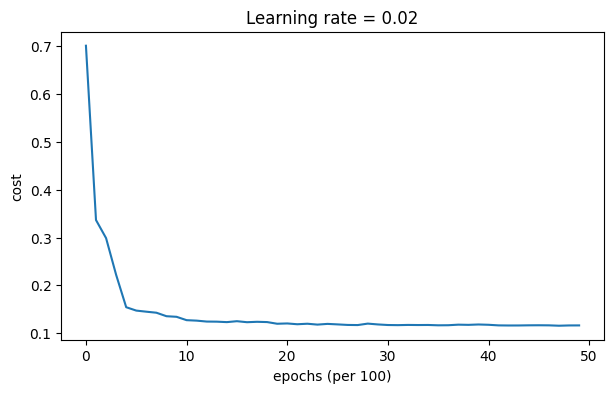

Accuracy: 0.9433333333333334


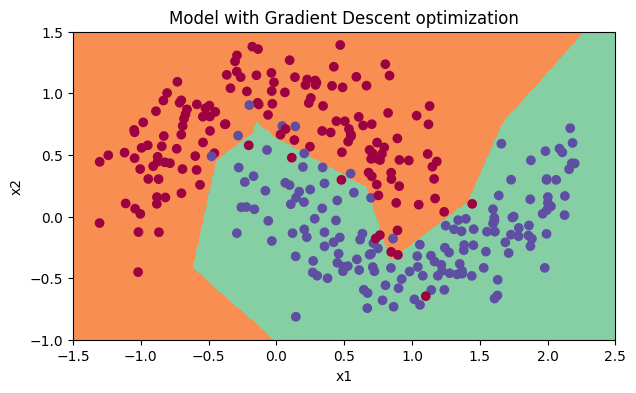

In [49]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd", learning_rate = 0.1, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.702226
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.128974
learning rate after epoch 1000: 0.050000
Cost after epoch 2000: 0.125965
learning rate after epoch 2000: 0.033333
Cost after epoch 3000: 0.123375
learning rate after epoch 3000: 0.025000
Cost after epoch 4000: 0.123218
learning rate after epoch 4000: 0.020000


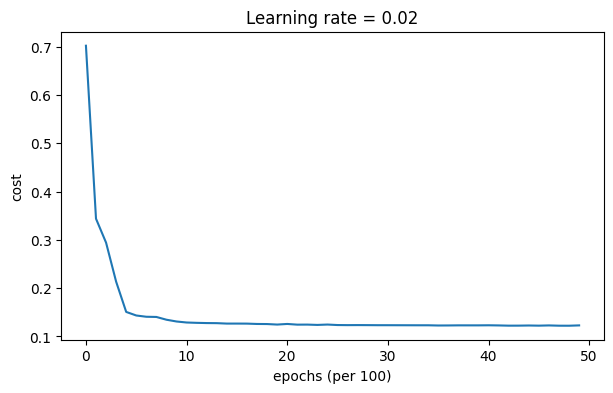

Accuracy: 0.9533333333333334


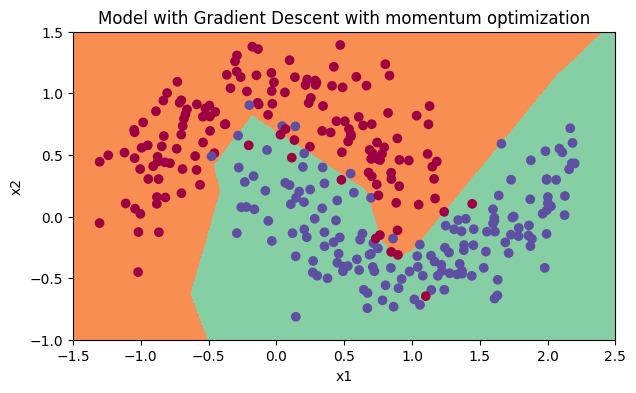

In [50]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "momentum", learning_rate = 0.1, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent with momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.699346
learning rate after epoch 0: 0.010000
Cost after epoch 1000: 0.130074
learning rate after epoch 1000: 0.005000
Cost after epoch 2000: 0.129826
learning rate after epoch 2000: 0.003333
Cost after epoch 3000: 0.129282
learning rate after epoch 3000: 0.002500
Cost after epoch 4000: 0.128361
learning rate after epoch 4000: 0.002000


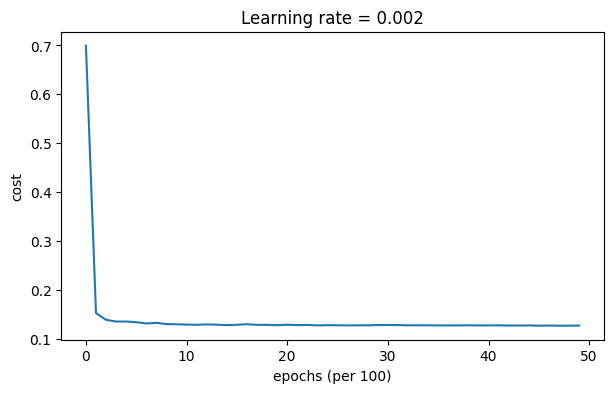

Accuracy: 0.94


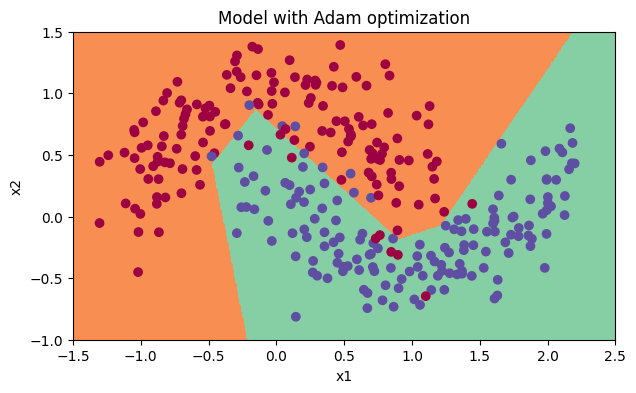

In [51]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam", learning_rate = 0.01, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

With Mini-batch GD or Mini-batch GD with Momentum, the accuracy is significantly lower than Adam, but when learning rate decay is added on top, either can achieve performance at a speed and accuracy score that's similar to Adam.